# 만들어진 Word2Vec model을 통한 감정분석 실시
> * Positive or Negative

In [1]:
import pickle
import html
import multiprocessing
from collections import namedtuple, OrderedDict
import re
import sys
import os

os.environ['KERAS_BACKEND']='tensorflow'

import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import pandas as pd

from gensim.models import Word2Vec, KeyedVectors
from gensim.models.doc2vec import TaggedDocument

from konlpy.utils import pprint

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import scale, MinMaxScaler
from sklearn.manifold import TSNE

import keras.backend.tensorflow_backend as K
from keras.preprocessing import sequence
from keras_tqdm import TQDMCallback, TQDMNotebookCallback
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.layers import Input, Flatten, Dense, Embedding, embeddings, merge, Dropout, Activation,  LSTM, Bidirectional, SimpleRNN, GRU
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.pooling import MaxPooling1D, GlobalMaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import SpatialDropout1D
from keras.utils import np_utils
from tensorflow.python.client import device_lib
from keras.layers.merge import dot


import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook

C:\Users\pc\Anaconda3\lib\site-packages\gensim\utils.py:1167: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\pc\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\pc\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
print (device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7680054348172846304
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4984510873
locality {
  bus_id: 1
}
incarnation: 9095378503400666912
physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:09:00.0, compute capability: 6.1"
]


In [3]:
def Make_Roc_Curve(x, y, model1, model2, model3, model4):
    print ('Logistic Regression')
    fpr1, tpr1, thresholds1 = roc_curve(y, model1.predict(x))
    print ('Random Forest')
    fpr2, tpr2, thresholds2 = roc_curve(y, model2.predict(x))
    print ('Kernel SVM')
    fpr3, tpr3, thresholds3 = roc_curve(y, model3.predict(x))
    print ('XGBoost')
    import xgboost as xgb
    fpr4, tpr4, thresholds4 = roc_curve(y, model4.predict(xgb.DMatrix(x)))
    plt.plot(fpr1, tpr1, label="Logistic Regression")
    plt.plot(fpr2, tpr2, label="RandomForest")
    plt.plot(fpr3, tpr3, label="Kernel SVM")
    plt.plot(fpr4, tpr4, label='XGBoost')
    plt.legend()
    plt.plot([0, 1], [0, 1], 'k--', label="random guess")
    plt.xlabel('False Positive Rate (Fall-Out)')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('Receiver operating characteristic example')
    plt.show()

In [4]:
def plot_history(history):
    """Plot model history after `fit()`.
    """

    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

In [5]:
def Make_TSNE1(n_component, model, wv, limit):
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    import pandas as pd
    from tqdm import tqdm
    tqdm.pandas(desc="progress-bar")
    wv = wv[:limit]
    tsne_model = TSNE(n_components=n_component,
                       verbose = 1, random_state = 0)
    tsne_w2v = tsne_model.fit_transform(wv)
    tsne_df = pd.DataFrame(tsne_w2v, columns = ['x', 'y'])
    tsne_df['words'] = list(model.wv.vocab.keys())[:limit]
    i = 0
    for i in tqdm(range(tsne_df['words'].size)):
        plt.scatter(tsne_df['x'][i], tsne_df['y'][i])
        plt.annotate(tsne_df['words'][i], 
                xy = (tsne_df['x'][i], tsne_df['y'][i]))
    plt.show()

In [6]:
def Make_TSNE2(n_component, model, wv, limit):
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    import pandas as pd
    from tqdm import tqdm
    import bokeh.plotting as bp
    from bokeh.models import HoverTool, BoxSelectTool
    from bokeh.plotting import figure, show, output_notebook
    
    output_notebook()
    plot_tfidf = bp.figure(plot_width=500, plot_height=500, title="A map of word vectors",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

    word_vectors = [model[w] for w in tqdm(list(model.wv.vocab.keys())[:limit])]

    tsne_model = TSNE(n_components=n_component, verbose=1, random_state=0)
    tsne_w2v = tsne_model.fit_transform(word_vectors)
    # putting everything in a dataframe
    tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
    tsne_df['words'] = list(model.wv.vocab.keys())[:limit]

    # plotting. the corresponding word appears when you hover on the data point.
    plot_tfidf.scatter(x='x', y='y', source=tsne_df)
    hover = plot_tfidf.select(dict(type=HoverTool))
    hover.tooltips={"word": "@words"}
    show(plot_tfidf)

In [7]:
def Build_tfidf(data):
    from sklearn.feature_extraction.text import TfidfVectorizer
    vectorizer = TfidfVectorizer(analyzer = lambda x: x, min_df = 2)
    matrix = vectorizer.fit_transform([x.words for x in tqdm(data)])
    print (matrix.shape)
    tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
    print ('vocab size : {}'.format(len(tfidf)))    
    return tfidf

In [8]:
def buildWordVector(tokens, model, size, tfidf):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model[word].reshape((1, size)) * tfidf[word]
            count += 1.
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

In [9]:
def Make_Pre_Data(model, tfidf, size, train, test):
    from datetime import datetime
    start = datetime.now()
    print (str(model))
    wv = [model[w] for w in tqdm(model.wv.vocab.keys())]
    process1 = datetime.now()
    print ('running time : {}'.format(process1 - start))
    
    print ('Vectorizing Train Data')
    train_vecs_w2v = np.concatenate([buildWordVector(z, model, size, tfidf) for z in tqdm(map(lambda x: x.words, train))])
    print ('scaling Train Data')
    train_vecs_w2v = scale(train_vecs_w2v)
    process2 = datetime.now()
    print ('running time : {}'.format(process2 - process1))
    
    print ('Vectorizing Test Data')
    test_vecs_w2v = np.concatenate([buildWordVector(z, model, size, tfidf) for z in tqdm(map(lambda x: x.words, test))])
    print ('scaling Test Data')
    test_vecs_w2v = scale(test_vecs_w2v)
    process3 = datetime.now()
    print ('running time : {}'.format(process3 - process2))
    
    print ('total running time : {}'.format(process3 - start))
    return wv, train_vecs_w2v, test_vecs_w2v

In [10]:
if sys.platform =='darwin':
    loadModelPath = '/Volumes/disk1/model/'
    #loadModelPath = './model/'
elif sys.platform =='win32':
    loadModelPath = 'd:/model/'
saveTrainPath = './data/pre_data/train_test_Data2/'
saveClassifierPath = './data/pre_data/classifier/'

In [11]:
def ReMake_Outcome(train_y, test_y):
    from tqdm import tqdm
    tqdm.pandas(desc="progress-bar") 
    train_y = [y[0] for y in tqdm(train_y)]
    test_y = [y[0] for y in tqdm(test_y)]
    return train_y, test_y

In [12]:
def Return_ModelName(model, tagger):
    size = model.vector_size
    epochs = model.epochs
    window = model.window
    negative = model.negative 
    hs = model.hs 
    sg = model.sg 
    cbow_mean = model.cbow_mean 
    min_count = model.min_count 
    min_alpha = model.min_alpha
    alpha = model.alpha
    modelName = 'word2vec_size-{}_epochs-{}_window-{}_negative-{}_hs-{}_sg-{}_cbow_mean-{}_min_count-{}_min_alpha-{}_alpha-{}_by-{}'.format(
    size, epochs, window, negative, hs, sg, cbow_mean, min_count, 
    min_alpha, alpha, tagger)
    return modelName

In [13]:
cores = int(multiprocessing.cpu_count() )
print (cores)

12


In [14]:
TaggedDocument = namedtuple('TaggedDocument', 'words tags sentiment')

## Twitter

###  Load Word2Vec model을 만들기 위해 사용한 사용된 train set

In [15]:
train = pickle.load(open('./data/pre_data/train_test_Data/pre_data_train_for_word2vec_sentiment_by_ct.pickled','rb'))
y_train = np.array([doc.sentiment for doc in tqdm(train)])

100%|██████████| 442359/442359 [00:00<00:00, 1467423.39it/s]


### train set을 사용하여 Tf-Idf vectorizer을 만듦

In [16]:
tfidf = Build_tfidf(train)

100%|██████████| 442359/442359 [00:00<00:00, 1467421.07it/s]


(442359, 159113)
vocab size : 159113


### Load Word2Vec model을 만들기 위해 사용한 사용된 testset

In [17]:
test = pickle.load(open('./data/pre_data/train_test_Data/pre_data_test_for_word2vec_sentiment_by_ct.pickled','rb'))
y_test = np.array([doc.sentiment for doc in tqdm(test)])

100%|██████████| 49151/49151 [00:00<00:00, 1291515.18it/s]


In [18]:
train_y2, test_y2 = ReMake_Outcome(y_train, y_test)

100%|██████████| 49151/49151 [00:00<00:00, 1044189.01it/s]


### Load Model

In [19]:
model1 = Word2Vec.load(loadModelPath+'word2vec_size-1000_epoch-20_window-10_negative-7_hs-0_sg-0_cbow_mean-0_min_count-2_by-ct.model')
model2 = Word2Vec.load(loadModelPath+'word2vec_size-1000_epoch-20_window-10_negative-7_hs-0_sg-0_cbow_mean-1_min_count-2_by-ct.model')
model3 = Word2Vec.load(loadModelPath+'word2vec_size-1000_epoch-20_window-10_negative-7_hs-0_sg-1_cbow_mean-0_min_count-2_by-ct.model')

### Model_1

In [20]:
wv1, train_vecs_w2v, test_vecs_w2v = Make_Pre_Data(model1, tfidf, 1000, train, test)
modelName = Return_ModelName(model1,'ct')

Word2Vec(vocab=162640, size=1000, alpha=0.025)


  0%|          | 0/162640 [00:00<?, ?it/s]C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
100%|██████████| 162640/162640 [00:01<00:00, 134656.10it/s]


running time : 0:00:01.213826
Vectorizing Train Data


0it [00:00, ?it/s]C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
442359it [13:02, 565.43it/s]


scaling Train Data
running time : 0:14:37.717360
Vectorizing Test Data


49151it [01:54, 430.69it/s]


scaling Test Data
running time : 0:01:56.765301
total running time : 0:16:35.696487


C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  if __name__ == '__main__':


#### t-SNE
> * t-분포 확률적 임베딩
> * 데이터의 차원 축소에 사용되는 기계 학습 알고리즘
> * 비선형 차원 축소 기법으로 고차원 데이터를 특히 2, 3차원 등으로 줄여 가시화하는데에 유용하게 사용
> * 비슷한 데이터는 근접한 2, 3차원의 지점으로, 다른 데이터는 멀리 떨어진 지점으로 맵핑
##### word : 10000

In [21]:
%%time
Make_TSNE2(2, model1, wv1, 10000)

Loading BokehJS ...

  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
100%|██████████| 10000/10000 [00:00<00:00, 124658.33it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.567s...
[t-SNE] Computed neighbors for 10000 samples in 176.310s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.160448
[t-SNE] KL divergence after 250 iterations with early exaggeration: 139.554871
[t-SNE] Error after 1000 iterations: 3.986189


Wall time: 9min 14s


#### 분류모델 : Logistic Regression

In [22]:
%%time
classifier = LogisticRegression(max_iter = 250, n_jobs = cores)
classifier.fit(train_vecs_w2v, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_vecs_w2v)))
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+modelName, 'wb'))

C:\Users\pc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(self.n_jobs))


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'multi_class': 'ovr', 'n_jobs': 12, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.7800858578665745
classification report
             precision    recall  f1-score   support

          0       0.77      0.81      0.79     25294
          1       0.79      0.75      0.77     23857

avg / total       0.78      0.78      0.78     49151

Wall time: 17min 2s


#### 분류모델 : Random Forest

In [23]:
%%time
classifier2 = RandomForestClassifier(n_estimators = 75, n_jobs = cores)
classifier2.fit(train_vecs_w2v, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_vecs_w2v)))
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+modelName, 'wb'))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 75, 'n_jobs': 12, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
score : 0.7385811072002604
classification report
             precision    recall  f1-score   support

          0       0.75      0.73      0.74     25294
          1       0.72      0.75      0.74     23857

avg / total       0.74      0.74      0.74     49151

Wall time: 4min 40s


#### 분류모델 : C - Support Vector Classification

In [24]:
%%time
scaling = MinMaxScaler(feature_range=(-1, 1)).fit(train_vecs_w2v)
train_vecs_w2v2 = scaling.transform(train_vecs_w2v)
test_vecs_w2v2 = scaling.transform(test_vecs_w2v)
classifier3 =  SVC(kernel = 'linear',
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_vecs_w2v2, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_vecs_w2v2, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_vecs_w2v2)))
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+modelName, 'wb'))

[LibSVM]

C:\Users\pc\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'C': 1.0, 'cache_size': 1024, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'max_iter': 1500, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': True}
score : 0.4885556753677443
classification report
             precision    recall  f1-score   support

          0       0.68      0.01      0.02     25294
          1       0.49      0.99      0.65     23857

avg / total       0.59      0.49      0.33     49151

Wall time: 20min 51s


#### 분류모델 : XGBOOST

In [25]:
max_depth = 5
subsample = 0.7
colsample_bytree= 0.7
params ={
        "objective": "binary:logistic",
        "booster" : "gbtree",
        "eval_metric": "auc",
        "max_depth" : max_depth,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "silent":1,
    'eta':0.125,
    'nthread' : cores
    
    }
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

In [26]:
dtrain = xgb.DMatrix(train_vecs_w2v, y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, y_test)

In [27]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist, early_stopping_rounds = early_stopping_rounds, verbose_eval = True)
test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_class = np.round(test_prediction)
print (accuracy_score(y_test, test_class))
print (classification_report(y_test, test_class))
gbm.save_model(saveClassifierPath+'XGBoost_'+modelName)

[0]	train-auc:0.648941	eval-auc:0.640333
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.678303	eval-auc:0.669386
[2]	train-auc:0.698875	eval-auc:0.689829
[3]	train-auc:0.708905	eval-auc:0.698776
[4]	train-auc:0.720002	eval-auc:0.708942
[5]	train-auc:0.726408	eval-auc:0.715421
[6]	train-auc:0.732849	eval-auc:0.721097
[7]	train-auc:0.739849	eval-auc:0.728383
[8]	train-auc:0.742886	eval-auc:0.731867
[9]	train-auc:0.746737	eval-auc:0.735348
[10]	train-auc:0.751962	eval-auc:0.740182
[11]	train-auc:0.755802	eval-auc:0.743785
[12]	train-auc:0.759129	eval-auc:0.746468
[13]	train-auc:0.762562	eval-auc:0.749732
[14]	train-auc:0.765513	eval-auc:0.752822
[15]	train-auc:0.769339	eval-auc:0.756562
[16]	train-auc:0.771448	eval-auc:0.758219
[17]	train-auc:0.774497	eval-auc:0.761375
[18]	train-auc:0.776484	eval-auc:0.763155
[19]	train-auc:0.779511	eval-auc:0.766017
[20]	train-auc:0.781811	eval-

[191]	train-auc:0.882742	eval-auc:0.854926
[192]	train-auc:0.88295	eval-auc:0.855094
[193]	train-auc:0.883163	eval-auc:0.855231
[194]	train-auc:0.883373	eval-auc:0.85533
[195]	train-auc:0.883593	eval-auc:0.855495
[196]	train-auc:0.883821	eval-auc:0.855592
[197]	train-auc:0.884039	eval-auc:0.855772
[198]	train-auc:0.884233	eval-auc:0.855901
[199]	train-auc:0.884443	eval-auc:0.856017
0.7724563081117373
             precision    recall  f1-score   support

          0       0.78      0.77      0.78     25294
          1       0.76      0.78      0.77     23857

avg / total       0.77      0.77      0.77     49151



Logistic Regression
Random Forest
Kernel SVM
XGBoost


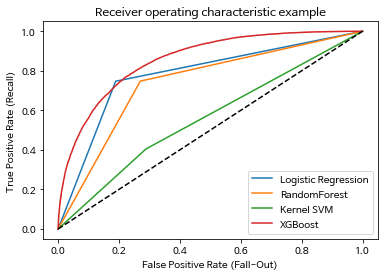

Wall time: 1min 37s


In [28]:
%%time
Make_Roc_Curve(test_vecs_w2v, y_test, classifier, classifier2, classifier3, gbm)

In [29]:
del classifier
del classifier2
del classifier3
del gbm

## Neural Network

In [30]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=1000))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train, epochs=200, batch_size = 200000, verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])

score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_1_'+modelName)

HBox(children=(IntProgress(value=0, description='Training', max=200), HTML(value='')))


Score: 0.5000
Accuracy: 0.7877


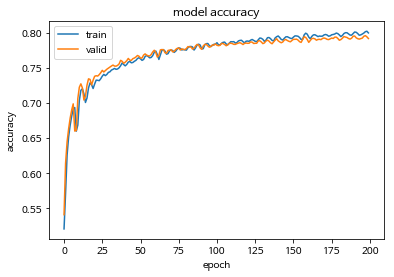

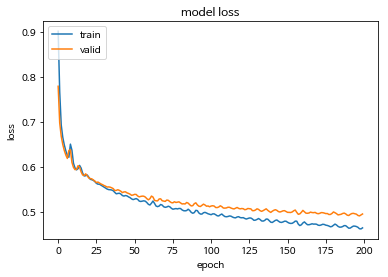

In [31]:
plot_history(history)

In [32]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=1000))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adadelta',
    loss='binary_crossentropy',
    metrics=['accuracy'])

history = model.fit(train_vecs_w2v, y_train, epochs=200, batch_size = 200000, verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_2_'+modelName)

HBox(children=(IntProgress(value=0, description='Training', max=200), HTML(value='')))


Score: 0.5012
Accuracy: 0.7846


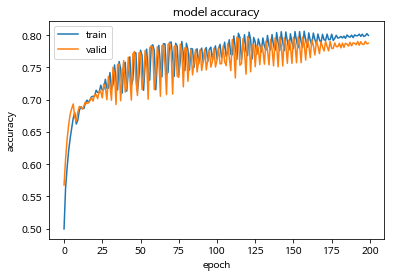

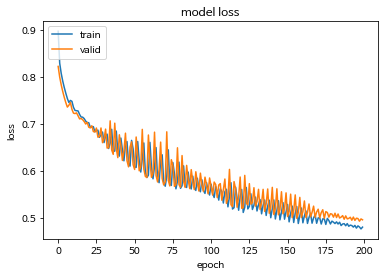

In [33]:
plot_history(history)

### Model_2

In [20]:
wv1, train_vecs_w2v, test_vecs_w2v = Make_Pre_Data(model2, tfidf, 1000, train, test)
modelName = Return_ModelName(model2,'ct')

Word2Vec(vocab=162640, size=1000, alpha=0.025)


  0%|          | 0/162640 [00:00<?, ?it/s]C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
100%|██████████| 162640/162640 [00:01<00:00, 132475.57it/s]


running time : 0:00:01.232706
Vectorizing Train Data


0it [00:00, ?it/s]C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
442359it [13:02, 565.61it/s]


scaling Train Data
running time : 0:49:12.701054
Vectorizing Test Data


49151it [01:53, 431.95it/s]


scaling Test Data
running time : 0:01:55.482396
total running time : 0:51:09.416156


C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  if __name__ == '__main__':


#### t-SNE
> * t-분포 확률적 임베딩
> * 데이터의 차원 축소에 사용되는 기계 학습 알고리즘
> * 비선형 차원 축소 기법으로 고차원 데이터를 특히 2, 3차원 등으로 줄여 가시화하는데에 유용하게 사용
> * 비슷한 데이터는 근접한 2, 3차원의 지점으로, 다른 데이터는 멀리 떨어진 지점으로 맵핑
##### word : 10000

In [35]:
%%time
Make_TSNE2(2, model2, wv1, 10000)

Loading BokehJS ...

  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
100%|██████████| 10000/10000 [00:00<00:00, 102945.39it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.527s...
[t-SNE] Computed neighbors for 10000 samples in 163.050s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.294552
[t-SNE] KL divergence after 250 iterations with early exaggeration: 97.109703
[t-SNE] Error after 1000 iterations: 2.667482


Wall time: 7min 22s


#### 분류모델 : Logistic Regression

In [36]:
%%time
classifier = LogisticRegression(max_iter = 250, n_jobs = cores)
classifier.fit(train_vecs_w2v, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_vecs_w2v)))
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+modelName, 'wb'))

C:\Users\pc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(self.n_jobs))


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'multi_class': 'ovr', 'n_jobs': 12, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.8156904233891478
classification report
             precision    recall  f1-score   support

          0       0.81      0.83      0.82     25294
          1       0.82      0.80      0.81     23857

avg / total       0.82      0.82      0.82     49151

Wall time: 3min 32s


#### 분류모델 : Random Forest

In [37]:
%%time
classifier2 = RandomForestClassifier(n_estimators = 75, n_jobs = cores)
classifier2.fit(train_vecs_w2v, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_vecs_w2v)))
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+modelName, 'wb'))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 75, 'n_jobs': 12, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
score : 0.8036255620434986
classification report
             precision    recall  f1-score   support

          0       0.81      0.80      0.81     25294
          1       0.79      0.81      0.80     23857

avg / total       0.80      0.80      0.80     49151

Wall time: 4min 39s


#### 분류모델 : C - Support Vector Classification

In [38]:
%%time
scaling = MinMaxScaler(feature_range=(-1, 1)).fit(train_vecs_w2v)
train_vecs_w2v2 = scaling.transform(train_vecs_w2v)
test_vecs_w2v2 = scaling.transform(test_vecs_w2v)
classifier3 =  SVC(kernel = 'linear',
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_vecs_w2v2, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_vecs_w2v2, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_vecs_w2v2)))
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+modelName, 'wb'))

[LibSVM]

C:\Users\pc\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'C': 1.0, 'cache_size': 1024, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'max_iter': 1500, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': True}
score : 0.4966531708408781
classification report
             precision    recall  f1-score   support

          0       0.72      0.04      0.07     25294
          1       0.49      0.98      0.66     23857

avg / total       0.61      0.50      0.35     49151

Wall time: 22min 56s


#### 분류모델 : XGBOOST

In [39]:
max_depth = 5
subsample = 0.7
colsample_bytree= 0.7
params ={
        "objective": "binary:logistic",
        "booster" : "gbtree",
        "eval_metric": "auc",
        "max_depth" : max_depth,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "silent":1,
    'eta':0.125,
    'nthread' : cores
    
    }
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

In [40]:
dtrain = xgb.DMatrix(train_vecs_w2v, y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, y_test)

In [41]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist, early_stopping_rounds = early_stopping_rounds, verbose_eval = True)
test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_class = np.round(test_prediction)
print (accuracy_score(y_test, test_class))
print (classification_report(y_test, test_class))
gbm.save_model(saveClassifierPath+'XGBoost_'+modelName)

[0]	train-auc:0.734326	eval-auc:0.733481
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.761515	eval-auc:0.759457
[2]	train-auc:0.77645	eval-auc:0.773442
[3]	train-auc:0.78833	eval-auc:0.783347
[4]	train-auc:0.798459	eval-auc:0.79328
[5]	train-auc:0.803626	eval-auc:0.798504
[6]	train-auc:0.808088	eval-auc:0.802557
[7]	train-auc:0.813145	eval-auc:0.807788
[8]	train-auc:0.817933	eval-auc:0.812026
[9]	train-auc:0.821834	eval-auc:0.815802
[10]	train-auc:0.824689	eval-auc:0.818632
[11]	train-auc:0.828197	eval-auc:0.822027
[12]	train-auc:0.830581	eval-auc:0.824612
[13]	train-auc:0.83373	eval-auc:0.828133
[14]	train-auc:0.836921	eval-auc:0.831078
[15]	train-auc:0.839571	eval-auc:0.833577
[16]	train-auc:0.841566	eval-auc:0.835385
[17]	train-auc:0.843435	eval-auc:0.83724
[18]	train-auc:0.844975	eval-auc:0.838539
[19]	train-auc:0.84682	eval-auc:0.84033
[20]	train-auc:0.848474	eval-auc:0.8

[191]	train-auc:0.923035	eval-auc:0.906962
[192]	train-auc:0.923205	eval-auc:0.907054
[193]	train-auc:0.923341	eval-auc:0.907126
[194]	train-auc:0.923506	eval-auc:0.907237
[195]	train-auc:0.923653	eval-auc:0.907308
[196]	train-auc:0.923793	eval-auc:0.907357
[197]	train-auc:0.923969	eval-auc:0.907476
[198]	train-auc:0.924127	eval-auc:0.907605
[199]	train-auc:0.924261	eval-auc:0.907689
0.8247441557648878
             precision    recall  f1-score   support

          0       0.83      0.82      0.83     25294
          1       0.82      0.82      0.82     23857

avg / total       0.82      0.82      0.82     49151



Logistic Regression
Random Forest
Kernel SVM
XGBoost


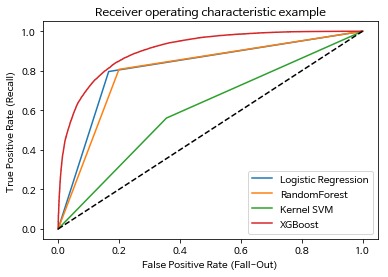

Wall time: 1min 57s


In [42]:
%%time
Make_Roc_Curve(test_vecs_w2v, y_test, classifier, classifier2, classifier3, gbm)

In [43]:
del classifier
del classifier2
del classifier3
del gbm

## Neural Network

In [21]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=1000))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train, epochs=200, batch_size = 200000, verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])

score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_1_'+modelName)

HBox(children=(IntProgress(value=0, description='Training', max=200), HTML(value='')))


Score: 0.4048
Accuracy: 0.8318


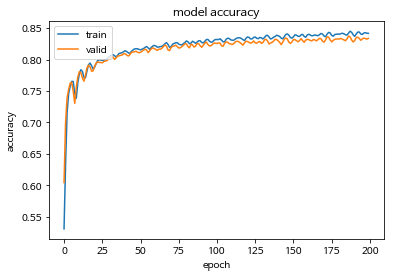

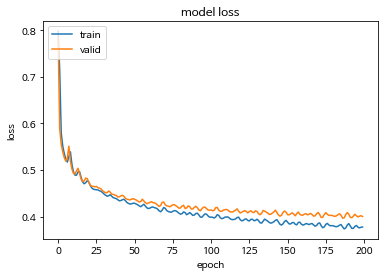

In [22]:
plot_history(history)

In [23]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=1000))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adadelta',
    loss='binary_crossentropy',
    metrics=['accuracy'])

history = model.fit(train_vecs_w2v, y_train, epochs=200, batch_size = 200000, verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_2_'+modelName)

HBox(children=(IntProgress(value=0, description='Training', max=200), HTML(value='')))


Score: 0.4250
Accuracy: 0.8336


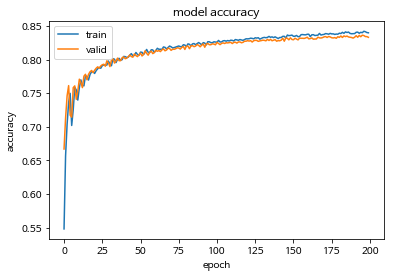

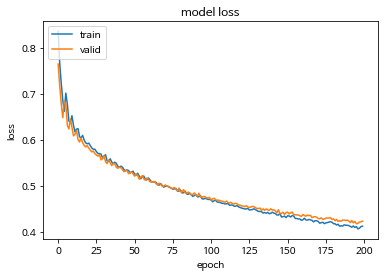

In [24]:
plot_history(history)

### Model_3

In [20]:
wv1, train_vecs_w2v, test_vecs_w2v = Make_Pre_Data(model3, tfidf, 1000, train, test)
modelName = Return_ModelName(model3,'ct')

Word2Vec(vocab=162640, size=1000, alpha=0.025)


  0%|          | 0/162640 [00:00<?, ?it/s]C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
100%|██████████| 162640/162640 [00:01<00:00, 132566.55it/s]


running time : 0:00:01.231628
Vectorizing Train Data


0it [00:00, ?it/s]C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
442359it [12:47, 576.53it/s]


scaling Train Data
running time : 0:21:34.437053
Vectorizing Test Data


49151it [02:20, 350.03it/s]


scaling Test Data
running time : 0:02:25.258541
total running time : 0:24:00.927222


C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  if __name__ == '__main__':


#### t-SNE
> * t-분포 확률적 임베딩
> * 데이터의 차원 축소에 사용되는 기계 학습 알고리즘
> * 비선형 차원 축소 기법으로 고차원 데이터를 특히 2, 3차원 등으로 줄여 가시화하는데에 유용하게 사용
> * 비슷한 데이터는 근접한 2, 3차원의 지점으로, 다른 데이터는 멀리 떨어진 지점으로 맵핑
##### word : 10000

In [21]:
%%time
Make_TSNE2(2, model3, wv1, 10000)

Loading BokehJS ...

  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
100%|██████████| 10000/10000 [00:00<00:00, 81137.47it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.590s...
[t-SNE] Computed neighbors for 10000 samples in 162.629s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.253565
[t-SNE] KL divergence after 250 iterations with early exaggeration: 97.253052
[t-SNE] Error after 1000 iterations: 2.959309


Wall time: 8min 51s


#### 분류모델 : Logistic Regression

In [22]:
%%time
classifier = LogisticRegression(max_iter = 250, n_jobs = cores)
classifier.fit(train_vecs_w2v, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_vecs_w2v)))
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+modelName, 'wb'))

C:\Users\pc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(self.n_jobs))


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'multi_class': 'ovr', 'n_jobs': 12, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.8278163211328355
classification report
             precision    recall  f1-score   support

          0       0.83      0.84      0.83     25294
          1       0.83      0.81      0.82     23857

avg / total       0.83      0.83      0.83     49151

Wall time: 2min 41s


#### 분류모델 : Random Forest

In [23]:
%%time
classifier2 = RandomForestClassifier(n_estimators = 75, n_jobs = cores)
classifier2.fit(train_vecs_w2v, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_vecs_w2v)))
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+modelName, 'wb'))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 75, 'n_jobs': 12, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
score : 0.8030558889951375
classification report
             precision    recall  f1-score   support

          0       0.81      0.80      0.81     25294
          1       0.79      0.81      0.80     23857

avg / total       0.80      0.80      0.80     49151

Wall time: 4min 47s


#### 분류모델 : C - Support Vector Classification

In [24]:
%%time
scaling = MinMaxScaler(feature_range=(-1, 1)).fit(train_vecs_w2v)
train_vecs_w2v2 = scaling.transform(train_vecs_w2v)
test_vecs_w2v2 = scaling.transform(test_vecs_w2v)
classifier3 =  SVC(kernel = 'linear',
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_vecs_w2v2, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_vecs_w2v2, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_vecs_w2v2)))
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+modelName, 'wb'))

[LibSVM]

C:\Users\pc\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'C': 1.0, 'cache_size': 1024, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'max_iter': 1500, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': True}
score : 0.4910785131533438
classification report
             precision    recall  f1-score   support

          0       0.69      0.02      0.04     25294
          1       0.49      0.99      0.65     23857

avg / total       0.59      0.49      0.34     49151

Wall time: 24min 20s


#### 분류모델 : XGBOOST

In [25]:
max_depth = 5
subsample = 0.7
colsample_bytree= 0.7
params ={
        "objective": "binary:logistic",
        "booster" : "gbtree",
        "eval_metric": "auc",
        "max_depth" : max_depth,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "silent":1,
    'eta':0.125,
    'nthread' : cores
    
    }
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

In [26]:
dtrain = xgb.DMatrix(train_vecs_w2v, y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, y_test)

In [27]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist, early_stopping_rounds = early_stopping_rounds, verbose_eval = True)
test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_class = np.round(test_prediction)
print (accuracy_score(y_test, test_class))
print (classification_report(y_test, test_class))
gbm.save_model(saveClassifierPath+'XGBoost_'+modelName)

[0]	train-auc:0.716229	eval-auc:0.715176
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.757325	eval-auc:0.754147
[2]	train-auc:0.769331	eval-auc:0.766844
[3]	train-auc:0.775142	eval-auc:0.773493
[4]	train-auc:0.783682	eval-auc:0.781274
[5]	train-auc:0.791291	eval-auc:0.788834
[6]	train-auc:0.797464	eval-auc:0.794649
[7]	train-auc:0.80413	eval-auc:0.800893
[8]	train-auc:0.807801	eval-auc:0.804551
[9]	train-auc:0.812618	eval-auc:0.809383
[10]	train-auc:0.816142	eval-auc:0.81253
[11]	train-auc:0.820801	eval-auc:0.816955
[12]	train-auc:0.823614	eval-auc:0.819623
[13]	train-auc:0.825898	eval-auc:0.82215
[14]	train-auc:0.829403	eval-auc:0.825478
[15]	train-auc:0.832944	eval-auc:0.828823
[16]	train-auc:0.835933	eval-auc:0.831568
[17]	train-auc:0.838221	eval-auc:0.833668
[18]	train-auc:0.840528	eval-auc:0.835991
[19]	train-auc:0.843253	eval-auc:0.838535
[20]	train-auc:0.845063	eval-auc

[191]	train-auc:0.926678	eval-auc:0.910647
[192]	train-auc:0.926851	eval-auc:0.910773
[193]	train-auc:0.927008	eval-auc:0.910901
[194]	train-auc:0.927178	eval-auc:0.91102
[195]	train-auc:0.927328	eval-auc:0.911138
[196]	train-auc:0.927466	eval-auc:0.911217
[197]	train-auc:0.927647	eval-auc:0.911323
[198]	train-auc:0.927783	eval-auc:0.911399
[199]	train-auc:0.927942	eval-auc:0.911459
0.8297898313360867
             precision    recall  f1-score   support

          0       0.84      0.83      0.83     25294
          1       0.82      0.83      0.83     23857

avg / total       0.83      0.83      0.83     49151



Logistic Regression
Random Forest
Kernel SVM
XGBoost


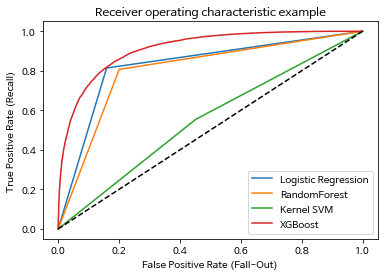

Wall time: 2min 8s


In [28]:
%%time
Make_Roc_Curve(test_vecs_w2v, y_test, classifier, classifier2, classifier3, gbm)

In [29]:
del classifier
del classifier2
del classifier3
del gbm

## Neural Network

In [30]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=1000))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train, epochs=200, batch_size = 200000, verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])

score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_1_'+modelName)

HBox(children=(IntProgress(value=0, description='Training', max=200), HTML(value='')))


Score: 0.3802
Accuracy: 0.8427


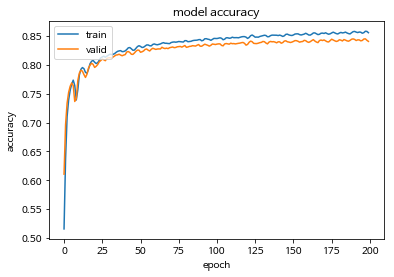

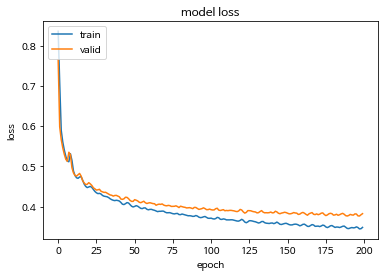

In [31]:
plot_history(history)

In [32]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=1000))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adadelta',
    loss='binary_crossentropy',
    metrics=['accuracy'])

history = model.fit(train_vecs_w2v, y_train, epochs=200, batch_size = 200000, verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_2_'+modelName)

HBox(children=(IntProgress(value=0, description='Training', max=200), HTML(value='')))


Score: 0.3928
Accuracy: 0.8487


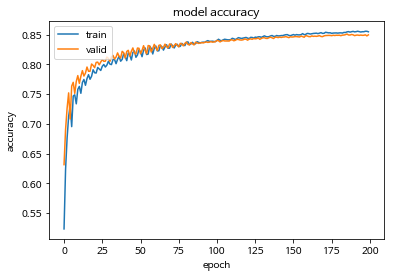

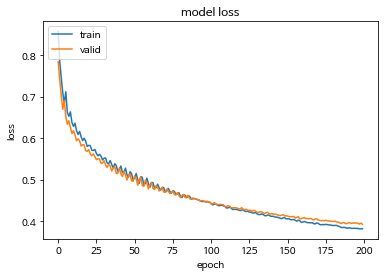

In [33]:
plot_history(history)

## Mecab

###  Load Word2Vec model을 만들기 위해 사용한 사용된 train set

In [34]:
train = pickle.load(open('./data/pre_data/train_test_Data/pre_data_train_for_word2vec_sentiment_by_mecab.pickled','rb'))
y_train = np.array([doc.sentiment for doc in tqdm(train)])

100%|██████████| 442359/442359 [00:00<00:00, 1346628.02it/s]


### train set을 사용하여 Tf-Idf vectorizer을 만듦

In [35]:
tfidf = Build_tfidf(train)

100%|██████████| 442359/442359 [00:00<00:00, 1462555.86it/s]


(442359, 161590)
vocab size : 161590


### Load Word2Vec model을 만들기 위해 사용한 사용된 testset

In [36]:
test = pickle.load(open('./data/pre_data/train_test_Data/pre_data_test_for_word2vec_sentiment_by_mecab.pickled','rb'))
y_test = np.array([doc.sentiment for doc in tqdm(test)])

100%|██████████| 49151/49151 [00:00<00:00, 981541.94it/s]


In [37]:
train_y2, test_y2 = ReMake_Outcome(y_train, y_test)

100%|██████████| 49151/49151 [00:00<00:00, 1066686.51it/s]


### Load Model

In [38]:
model1 = Word2Vec.load(loadModelPath+'word2vec_size-1000_epoch-20_window-10_negative-7_hs-0_sg-0_cbow_mean-0_min_count-2_by-mecab.model')
model2 = Word2Vec.load(loadModelPath+'word2vec_size-1000_epoch-20_window-10_negative-7_hs-0_sg-0_cbow_mean-1_min_count-2_by-mecab.model')
model3 = Word2Vec.load(loadModelPath+'word2vec_size-1000_epoch-20_window-10_negative-7_hs-0_sg-1_cbow_mean-0_min_count-2_by-mecab.model')

### Model_1 

In [39]:
wv1, train_vecs_w2v, test_vecs_w2v = Make_Pre_Data(model1, tfidf, 1000, train, test)
modelName = Return_ModelName(model1,'mecab')

Word2Vec(vocab=165361, size=1000, alpha=0.025)


  0%|          | 0/165361 [00:00<?, ?it/s]C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
100%|██████████| 165361/165361 [00:01<00:00, 117670.02it/s]


running time : 0:00:01.412297
Vectorizing Train Data


0it [00:00, ?it/s]C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
442359it [14:25, 510.88it/s]


scaling Train Data
running time : 0:26:22.396866
Vectorizing Test Data


49151it [06:13, 131.54it/s]


scaling Test Data
running time : 0:06:58.925695
total running time : 0:33:22.734858


C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  if __name__ == '__main__':


#### t-SNE
> * t-분포 확률적 임베딩
> * 데이터의 차원 축소에 사용되는 기계 학습 알고리즘
> * 비선형 차원 축소 기법으로 고차원 데이터를 특히 2, 3차원 등으로 줄여 가시화하는데에 유용하게 사용
> * 비슷한 데이터는 근접한 2, 3차원의 지점으로, 다른 데이터는 멀리 떨어진 지점으로 맵핑
##### word : 10000

In [40]:
%%time
Make_TSNE2(2, model1, wv1, 10000)

Loading BokehJS ...

  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
100%|██████████| 10000/10000 [00:00<00:00, 10189.05it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.572s...
[t-SNE] Computed neighbors for 10000 samples in 164.362s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.172262
[t-SNE] KL divergence after 250 iterations with early exaggeration: 138.274139
[t-SNE] Error after 1000 iterations: 3.953585


Wall time: 8min 44s


#### 분류모델 : Logistic Regression

In [41]:
%%time
classifier = LogisticRegression(max_iter = 250, n_jobs = cores)
classifier.fit(train_vecs_w2v, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_vecs_w2v)))
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+modelName, 'wb'))

C:\Users\pc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(self.n_jobs))


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'multi_class': 'ovr', 'n_jobs': 12, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.7896278814266241
classification report
             precision    recall  f1-score   support

          0       0.78      0.82      0.80     25279
          1       0.80      0.76      0.78     23872

avg / total       0.79      0.79      0.79     49151

Wall time: 43min 10s


#### 분류모델 : Random Forest

In [42]:
%%time
classifier2 = RandomForestClassifier(n_estimators = 75, n_jobs = cores)
classifier2.fit(train_vecs_w2v, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_vecs_w2v)))
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+modelName, 'wb'))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 75, 'n_jobs': 12, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
score : 0.7448068198002076
classification report
             precision    recall  f1-score   support

          0       0.76      0.74      0.75     25279
          1       0.73      0.75      0.74     23872

avg / total       0.74      0.74      0.74     49151

Wall time: 4min 28s


#### 분류모델 : C - Support Vector Classification

In [43]:
%%time
scaling = MinMaxScaler(feature_range=(-1, 1)).fit(train_vecs_w2v)
train_vecs_w2v2 = scaling.transform(train_vecs_w2v)
test_vecs_w2v2 = scaling.transform(test_vecs_w2v)
classifier3 =  SVC(kernel = 'linear',
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_vecs_w2v2, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_vecs_w2v2, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_vecs_w2v2)))
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+modelName, 'wb'))

[LibSVM]

C:\Users\pc\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'C': 1.0, 'cache_size': 1024, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'max_iter': 1500, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': True}
score : 0.48804703871742183
classification report
             precision    recall  f1-score   support

          0       0.73      0.01      0.01     25279
          1       0.49      1.00      0.65     23872

avg / total       0.61      0.49      0.33     49151

Wall time: 19min 50s


#### 분류모델 : XGBOOST

In [44]:
max_depth = 5
subsample = 0.7
colsample_bytree= 0.7
params ={
        "objective": "binary:logistic",
        "booster" : "gbtree",
        "eval_metric": "auc",
        "max_depth" : max_depth,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "silent":1,
    'eta':0.125,
    'nthread' : cores
    
    }
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

In [45]:
dtrain = xgb.DMatrix(train_vecs_w2v, y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, y_test)

In [46]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist, early_stopping_rounds = early_stopping_rounds, verbose_eval = True)
test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_class = np.round(test_prediction)
print (accuracy_score(y_test, test_class))
print (classification_report(y_test, test_class))
gbm.save_model(saveClassifierPath+'XGBoost_'+modelName)

[0]	train-auc:0.651843	eval-auc:0.648461
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.684843	eval-auc:0.679022
[2]	train-auc:0.701159	eval-auc:0.695333
[3]	train-auc:0.715657	eval-auc:0.710058
[4]	train-auc:0.724342	eval-auc:0.718608
[5]	train-auc:0.731179	eval-auc:0.724651
[6]	train-auc:0.738569	eval-auc:0.730711
[7]	train-auc:0.744344	eval-auc:0.736544
[8]	train-auc:0.748454	eval-auc:0.740912
[9]	train-auc:0.754314	eval-auc:0.746674
[10]	train-auc:0.758984	eval-auc:0.75089
[11]	train-auc:0.762703	eval-auc:0.754488
[12]	train-auc:0.765061	eval-auc:0.756489
[13]	train-auc:0.768509	eval-auc:0.759753
[14]	train-auc:0.772057	eval-auc:0.762823
[15]	train-auc:0.775402	eval-auc:0.765945
[16]	train-auc:0.778095	eval-auc:0.768515
[17]	train-auc:0.780404	eval-auc:0.770434
[18]	train-auc:0.783815	eval-auc:0.773281
[19]	train-auc:0.786253	eval-auc:0.775407
[20]	train-auc:0.788431	eval-a

[191]	train-auc:0.882504	eval-auc:0.856875
[192]	train-auc:0.882715	eval-auc:0.857035
[193]	train-auc:0.882974	eval-auc:0.857207
[194]	train-auc:0.883187	eval-auc:0.857368
[195]	train-auc:0.883414	eval-auc:0.85756
[196]	train-auc:0.883655	eval-auc:0.857734
[197]	train-auc:0.883858	eval-auc:0.857868
[198]	train-auc:0.884048	eval-auc:0.858008
[199]	train-auc:0.884222	eval-auc:0.85817
0.774124636324795
             precision    recall  f1-score   support

          0       0.78      0.78      0.78     25279
          1       0.77      0.77      0.77     23872

avg / total       0.77      0.77      0.77     49151



Logistic Regression
Random Forest
Kernel SVM
XGBoost


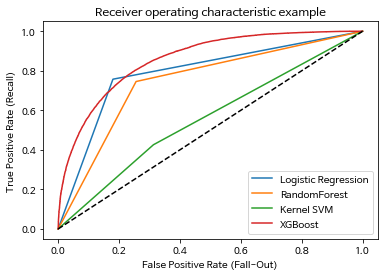

Wall time: 1min 34s


In [47]:
%%time
Make_Roc_Curve(test_vecs_w2v, y_test, classifier, classifier2, classifier3, gbm)

In [48]:
del classifier
del classifier2
del classifier3
del gbm

## Neural Network

In [49]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=1000))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train, epochs=200, batch_size = 200000, verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])

score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_1_'+modelName)

HBox(children=(IntProgress(value=0, description='Training', max=200), HTML(value='')))


Score: 0.4989
Accuracy: 0.7875


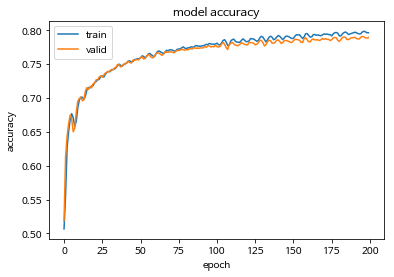

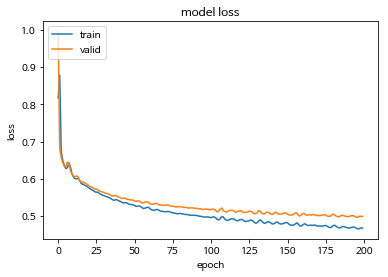

In [50]:
plot_history(history)

In [51]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=1000))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adadelta',
    loss='binary_crossentropy',
    metrics=['accuracy'])

history = model.fit(train_vecs_w2v, y_train, epochs=200, batch_size = 200000, verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_2_'+modelName)

HBox(children=(IntProgress(value=0, description='Training', max=200), HTML(value='')))


Score: 0.4933
Accuracy: 0.7875


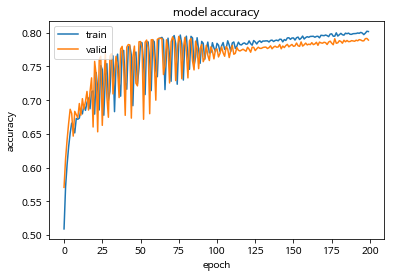

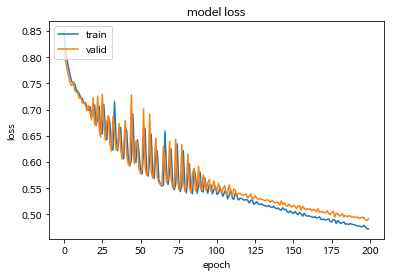

In [52]:
plot_history(history)

### Model_2 

In [53]:
wv1, train_vecs_w2v, test_vecs_w2v = Make_Pre_Data(model2, tfidf, 1000, train, test)
modelName = Return_ModelName(model2,'mecab')

Word2Vec(vocab=165361, size=1000, alpha=0.025)


  0%|          | 0/165361 [00:00<?, ?it/s]C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
100%|██████████| 165361/165361 [00:40<00:00, 4097.93it/s]


running time : 0:00:40.620824
Vectorizing Train Data


0it [00:00, ?it/s]C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
442359it [19:48, 372.31it/s]


scaling Train Data
running time : 0:40:25.287559
Vectorizing Test Data


49151it [07:56, 103.23it/s]


scaling Test Data
running time : 0:09:10.614807
total running time : 0:50:16.523190


C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  if __name__ == '__main__':


#### t-SNE
> * t-분포 확률적 임베딩
> * 데이터의 차원 축소에 사용되는 기계 학습 알고리즘
> * 비선형 차원 축소 기법으로 고차원 데이터를 특히 2, 3차원 등으로 줄여 가시화하는데에 유용하게 사용
> * 비슷한 데이터는 근접한 2, 3차원의 지점으로, 다른 데이터는 멀리 떨어진 지점으로 맵핑
##### word : 10000

In [54]:
%%time
Make_TSNE2(2, model2, wv1, 10000)

Loading BokehJS ...

  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
100%|██████████| 10000/10000 [00:00<00:00, 43323.41it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.573s...
[t-SNE] Computed neighbors for 10000 samples in 162.883s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.291766
[t-SNE] KL divergence after 250 iterations with early exaggeration: 97.226311
[t-SNE] Error after 1000 iterations: 2.701294


Wall time: 7min 6s


#### 분류모델 : Logistic Regression

In [55]:
%%time
classifier = LogisticRegression(max_iter = 250, n_jobs = cores)
classifier.fit(train_vecs_w2v, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_vecs_w2v)))
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+modelName, 'wb'))

C:\Users\pc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(self.n_jobs))


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'multi_class': 'ovr', 'n_jobs': 12, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.8189863888832374
classification report
             precision    recall  f1-score   support

          0       0.82      0.84      0.83     25279
          1       0.82      0.80      0.81     23872

avg / total       0.82      0.82      0.82     49151

Wall time: 4min 52s


#### 분류모델 : Random Forest

In [56]:
%%time
classifier2 = RandomForestClassifier(n_estimators = 75, n_jobs = cores)
classifier2.fit(train_vecs_w2v, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_vecs_w2v)))
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+modelName, 'wb'))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 75, 'n_jobs': 12, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
score : 0.8025879432768408
classification report
             precision    recall  f1-score   support

          0       0.81      0.81      0.81     25279
          1       0.80      0.80      0.80     23872

avg / total       0.80      0.80      0.80     49151

Wall time: 4min 35s


#### 분류모델 : C - Support Vector Classification

In [57]:
%%time
scaling = MinMaxScaler(feature_range=(-1, 1)).fit(train_vecs_w2v)
train_vecs_w2v2 = scaling.transform(train_vecs_w2v)
test_vecs_w2v2 = scaling.transform(test_vecs_w2v)
classifier3 =  SVC(kernel = 'linear',
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_vecs_w2v2, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_vecs_w2v2, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_vecs_w2v2)))
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+modelName, 'wb'))

[LibSVM]

C:\Users\pc\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'C': 1.0, 'cache_size': 1024, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'max_iter': 1500, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': True}
score : 0.49170922259974364
classification report
             precision    recall  f1-score   support

          0       0.76      0.02      0.03     25279
          1       0.49      0.99      0.66     23872

avg / total       0.63      0.49      0.34     49151

Wall time: 21min 46s


#### 분류모델 : XGBOOST

In [58]:
max_depth = 5
subsample = 0.7
colsample_bytree= 0.7
params ={
        "objective": "binary:logistic",
        "booster" : "gbtree",
        "eval_metric": "auc",
        "max_depth" : max_depth,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "silent":1,
    'eta':0.125,
    'nthread' : cores
    
    }
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

In [59]:
dtrain = xgb.DMatrix(train_vecs_w2v, y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, y_test)

In [60]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist, early_stopping_rounds = early_stopping_rounds, verbose_eval = True)
test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_class = np.round(test_prediction)
print (accuracy_score(y_test, test_class))
print (classification_report(y_test, test_class))
gbm.save_model(saveClassifierPath+'XGBoost_'+modelName)

[0]	train-auc:0.736108	eval-auc:0.737226
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.766352	eval-auc:0.76657
[2]	train-auc:0.782069	eval-auc:0.781888
[3]	train-auc:0.788867	eval-auc:0.788805
[4]	train-auc:0.793169	eval-auc:0.793193
[5]	train-auc:0.803441	eval-auc:0.803056
[6]	train-auc:0.807557	eval-auc:0.806926
[7]	train-auc:0.812811	eval-auc:0.812286
[8]	train-auc:0.817669	eval-auc:0.816603
[9]	train-auc:0.821268	eval-auc:0.820216
[10]	train-auc:0.824448	eval-auc:0.823334
[11]	train-auc:0.827304	eval-auc:0.826187
[12]	train-auc:0.830166	eval-auc:0.829039
[13]	train-auc:0.833253	eval-auc:0.832127
[14]	train-auc:0.835702	eval-auc:0.834364
[15]	train-auc:0.837984	eval-auc:0.83669
[16]	train-auc:0.840227	eval-auc:0.838749
[17]	train-auc:0.841996	eval-auc:0.840295
[18]	train-auc:0.844083	eval-auc:0.842278
[19]	train-auc:0.846032	eval-auc:0.844033
[20]	train-auc:0.847879	eval-au

[191]	train-auc:0.92039	eval-auc:0.90632
[192]	train-auc:0.920507	eval-auc:0.90642
[193]	train-auc:0.920687	eval-auc:0.906572
[194]	train-auc:0.920839	eval-auc:0.90668
[195]	train-auc:0.920958	eval-auc:0.906747
[196]	train-auc:0.921125	eval-auc:0.906867
[197]	train-auc:0.921249	eval-auc:0.906954
[198]	train-auc:0.921416	eval-auc:0.907052
[199]	train-auc:0.921599	eval-auc:0.907187
0.8249476104250167
             precision    recall  f1-score   support

          0       0.83      0.83      0.83     25279
          1       0.82      0.82      0.82     23872

avg / total       0.82      0.82      0.82     49151



Logistic Regression
Random Forest
Kernel SVM
XGBoost


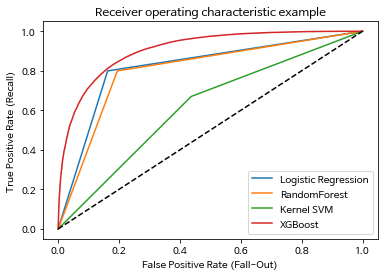

Wall time: 1min 46s


In [61]:
%%time
Make_Roc_Curve(test_vecs_w2v, y_test, classifier, classifier2, classifier3, gbm)

In [62]:
del classifier
del classifier2
del classifier3
del gbm

## Neural Network

In [63]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=1000))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train, epochs=200, batch_size = 200000, verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])

score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_1_'+modelName)

HBox(children=(IntProgress(value=0, description='Training', max=200), HTML(value='')))


Score: 0.4078
Accuracy: 0.8294


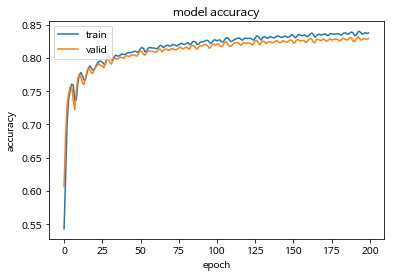

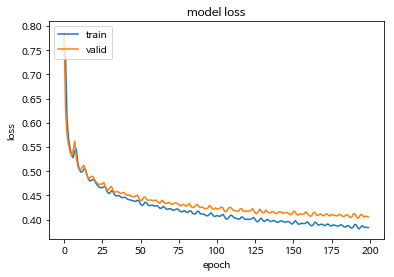

In [64]:
plot_history(history)

In [65]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=1000))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adadelta',
    loss='binary_crossentropy',
    metrics=['accuracy'])

history = model.fit(train_vecs_w2v, y_train, epochs=200, batch_size = 200000, verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_2_'+modelName)

HBox(children=(IntProgress(value=0, description='Training', max=200), HTML(value='')))


Score: 0.4251
Accuracy: 0.8340


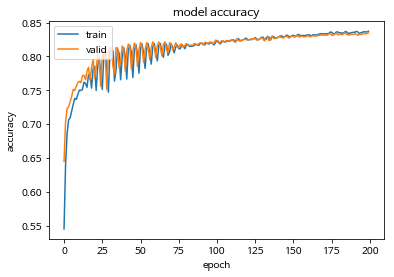

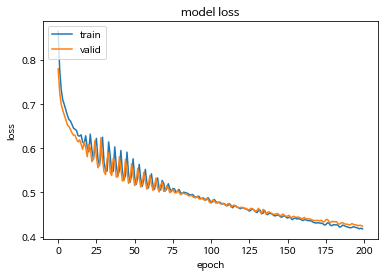

In [66]:
plot_history(history)

### Model_3

In [67]:
wv1, train_vecs_w2v, test_vecs_w2v = Make_Pre_Data(model3, tfidf, 1000, train, test)
modelName = Return_ModelName(model3,'mecab')

Word2Vec(vocab=165361, size=1000, alpha=0.025)


  0%|          | 0/165361 [00:00<?, ?it/s]C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
100%|██████████| 165361/165361 [01:10<00:00, 2330.03it/s]


running time : 0:01:11.211854
Vectorizing Train Data


0it [00:00, ?it/s]C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
442359it [23:42, 311.07it/s]


scaling Train Data
running time : 0:27:10.361327
Vectorizing Test Data


49151it [05:08, 159.12it/s]


scaling Test Data
running time : 0:05:29.797018
total running time : 0:33:51.370199


C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  if __name__ == '__main__':


#### t-SNE
> * t-분포 확률적 임베딩
> * 데이터의 차원 축소에 사용되는 기계 학습 알고리즘
> * 비선형 차원 축소 기법으로 고차원 데이터를 특히 2, 3차원 등으로 줄여 가시화하는데에 유용하게 사용
> * 비슷한 데이터는 근접한 2, 3차원의 지점으로, 다른 데이터는 멀리 떨어진 지점으로 맵핑
##### word : 10000

In [68]:
%%time
Make_TSNE2(2, model3, wv1, 10000)

Loading BokehJS ...

  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
100%|██████████| 10000/10000 [00:00<00:00, 37775.77it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.657s...
[t-SNE] Computed neighbors for 10000 samples in 163.434s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.249663
[t-SNE] KL divergence after 250 iterations with early exaggeration: 96.182762
[t-SNE] Error after 1000 iterations: 2.990246


Wall time: 8min 14s


#### 분류모델 : Logistic Regression

In [69]:
%%time
classifier = LogisticRegression(max_iter = 250, n_jobs = cores)
classifier.fit(train_vecs_w2v, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_vecs_w2v)))
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+modelName, 'wb'))

C:\Users\pc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(self.n_jobs))


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'multi_class': 'ovr', 'n_jobs': 12, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.8292405037537385
classification report
             precision    recall  f1-score   support

          0       0.83      0.84      0.84     25279
          1       0.83      0.81      0.82     23872

avg / total       0.83      0.83      0.83     49151

Wall time: 3min 4s


#### 분류모델 : Random Forest

In [70]:
%%time
classifier2 = RandomForestClassifier(n_estimators = 75, n_jobs = cores)
classifier2.fit(train_vecs_w2v, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_vecs_w2v)))
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+modelName, 'wb'))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 75, 'n_jobs': 12, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
score : 0.8020589611605053
classification report
             precision    recall  f1-score   support

          0       0.81      0.80      0.81     25279
          1       0.79      0.80      0.80     23872

avg / total       0.80      0.80      0.80     49151

Wall time: 4min 37s


#### 분류모델 : C - Support Vector Classification

In [71]:
%%time
scaling = MinMaxScaler(feature_range=(-1, 1)).fit(train_vecs_w2v)
train_vecs_w2v2 = scaling.transform(train_vecs_w2v)
test_vecs_w2v2 = scaling.transform(test_vecs_w2v)
classifier3 =  SVC(kernel = 'linear',
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_vecs_w2v2, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_vecs_w2v2, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_vecs_w2v2)))
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+modelName, 'wb'))

[LibSVM]

C:\Users\pc\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'C': 1.0, 'cache_size': 1024, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'max_iter': 1500, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': True}
score : 0.4890439665520539
classification report
             precision    recall  f1-score   support

          0       0.64      0.01      0.03     25279
          1       0.49      0.99      0.65     23872

avg / total       0.57      0.49      0.33     49151

Wall time: 23min 59s


#### 분류모델 : XGBOOST

In [72]:
max_depth = 5
subsample = 0.7
colsample_bytree= 0.7
params ={
        "objective": "binary:logistic",
        "booster" : "gbtree",
        "eval_metric": "auc",
        "max_depth" : max_depth,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "silent":1,
    'eta':0.125,
    'nthread' : cores
    
    }
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

In [73]:
dtrain = xgb.DMatrix(train_vecs_w2v, y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, y_test)

In [74]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist, early_stopping_rounds = early_stopping_rounds, verbose_eval = True)
test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_class = np.round(test_prediction)
print (accuracy_score(y_test, test_class))
print (classification_report(y_test, test_class))
gbm.save_model(saveClassifierPath+'XGBoost_'+modelName)

[0]	train-auc:0.714701	eval-auc:0.70892
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.749368	eval-auc:0.743999
[2]	train-auc:0.763043	eval-auc:0.756636
[3]	train-auc:0.776181	eval-auc:0.769683
[4]	train-auc:0.786911	eval-auc:0.780843
[5]	train-auc:0.793768	eval-auc:0.787226
[6]	train-auc:0.800898	eval-auc:0.794265
[7]	train-auc:0.806695	eval-auc:0.799977
[8]	train-auc:0.811045	eval-auc:0.804147
[9]	train-auc:0.815285	eval-auc:0.808027
[10]	train-auc:0.819592	eval-auc:0.81241
[11]	train-auc:0.823471	eval-auc:0.816592
[12]	train-auc:0.826863	eval-auc:0.820129
[13]	train-auc:0.82962	eval-auc:0.822786
[14]	train-auc:0.832185	eval-auc:0.825371
[15]	train-auc:0.834806	eval-auc:0.827846
[16]	train-auc:0.837099	eval-auc:0.830124
[17]	train-auc:0.8391	eval-auc:0.832187
[18]	train-auc:0.841376	eval-auc:0.834734
[19]	train-auc:0.843537	eval-auc:0.836779
[20]	train-auc:0.845662	eval-auc:0

[191]	train-auc:0.924715	eval-auc:0.908571
[192]	train-auc:0.924865	eval-auc:0.908673
[193]	train-auc:0.92505	eval-auc:0.908816
[194]	train-auc:0.925201	eval-auc:0.908928
[195]	train-auc:0.925363	eval-auc:0.909085
[196]	train-auc:0.925515	eval-auc:0.909186
[197]	train-auc:0.925635	eval-auc:0.909273
[198]	train-auc:0.925786	eval-auc:0.909374
[199]	train-auc:0.925929	eval-auc:0.90947
0.8256190108034425
             precision    recall  f1-score   support

          0       0.83      0.83      0.83     25279
          1       0.82      0.82      0.82     23872

avg / total       0.83      0.83      0.83     49151



Logistic Regression
Random Forest
Kernel SVM
XGBoost


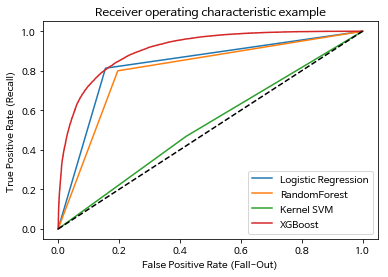

Wall time: 2min 31s


In [75]:
%%time
Make_Roc_Curve(test_vecs_w2v, y_test, classifier, classifier2, classifier3, gbm)

In [76]:
del classifier
del classifier2
del classifier3
del gbm

## Neural Network

In [ ]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=1000))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train, epochs=200, batch_size = 200000, verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])

score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_1_'+modelName)

HBox(children=(IntProgress(value=0, description='Training', max=200), HTML(value='')))

In [ ]:
plot_history(history)

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=1000))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adadelta',
    loss='binary_crossentropy',
    metrics=['accuracy'])

history = model.fit(train_vecs_w2v, y_train, epochs=200, batch_size = 200000, verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_2_'+modelName)

In [ ]:
plot_history(history)